In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
from rasterstats import point_query
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import rioxarray as rio
import rasterio
import pystac_client
import planetary_computer
from odc.stac import stac_load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rioxarray as rio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [2]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bbox = [lower_left[1], lower_left[0], upper_right[1], upper_right[0]]  # [min lon, min lat, max lon, max lat]

# Define time range (June 1 – Sep 1, 2021)
time_window = "2012-06-01/2025-02-01"

In [8]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search for Sentinel-2 images with <30% cloud cover
search = stac.search(
    bbox=bbox,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)

# Get item list
items = list(search.get_items())
print(f"✅ Number of Sentinel-2 scenes found: {len(items)}")

# Sign URLs for access
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

✅ Number of Sentinel-2 scenes found: 292


In [9]:
# Define pixel resolution (10m per pixel)
resolution = 10  # meters
scale = resolution / 111320.0  # degrees per pixel for CRS=4326

# Load spectral bands from Sentinel-2
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "AOT", "WVP", "SCL","B09"],
    crs="EPSG:4326",  
    resolution=scale,  
    chunks={"df": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bbox
)

print(data)

<xarray.Dataset> Size: 19GB
Dimensions:      (latitude: 1448, longitude: 1671, time: 264)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2015-08-02T15:51:36.027000 ... 202...
Data variables: (12/15)
    B01          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude)

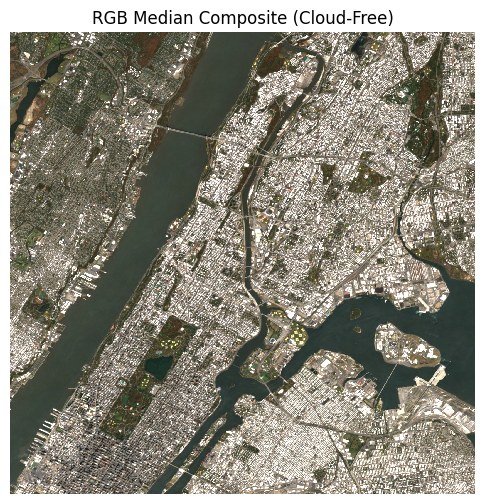

In [10]:
median = data.median(dim="time").compute()

# Display an RGB Image (B04, B03, B02)
fig, ax = plt.subplots(figsize=(6, 6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite (Cloud-Free)")
ax.axis('off')
plt.show()

In [11]:
filename = "Sentinel2_NYC2.tif"

# Define raster transform
height, width = median.dims["latitude"], median.dims["longitude"]
transform = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

# Write GeoTIFF
median.rio.write_crs("EPSG:4326", inplace=True)
median.rio.write_transform(transform, inplace=True)

with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs="EPSG:4326", transform=transform,
                   count=len(median.data_vars), dtype="float32") as dst:
    for i, band in enumerate(median.data_vars.keys()):
        dst.write(median[band], i + 1)

print(f"✅ GeoTIFF saved: {filename}")

✅ GeoTIFF saved: Sentinel2_NYC2.tif


In [12]:
import pandas as pd
import geopandas as gpd

# Load UHI observation dataset (CSV containing Lat, Lon, UHI Index)

uhi_data = pd.read_csv("UHI_Observation.csv")
uhi_gdf = gpd.GeoDataFrame(uhi_data, geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude), crs="EPSG:4326")

# Display sample
uhi_gdf.head()

,Longitude,Latitude,datetime,UHI Index,geometry
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (-73.90917 40.81311)
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (-73.90919 40.81304)
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (-73.90922 40.81298)
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (-73.90924 40.81291)
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (-73.90926 40.81284)


In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rioxarray as rio
from rasterio.features import geometry_mask
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [14]:
import rioxarray as rio

# Load the processed Sentinel-2 raster (GeoTIFF)
sentinel_raster = rio.open_rasterio("Sentinel2_NYC2.tif")

# Display available bands
print(f"✅ Bands in raster: {sentinel_raster.name}")

✅ Bands in raster: None


In [15]:
import os

raster_path = "Sentinel2_NYC1.tif"

if os.path.exists(raster_path):
    print("✅ File found:", raster_path)
else:
    print("❌ File NOT found. Check the file path!")


✅ File found: Sentinel2_NYC1.tif


In [16]:
import rasterio

with rasterio.open(raster_path) as src:
    print("✅ Raster CRS:", src.crs)
    print("✅ Raster Bands:", src.count)  # Number of bands
    print("✅ Raster Shape (Height df Width):", src.height, "df", src.width)

✅ Raster CRS: EPSG:4326
✅ Raster Bands: 15
✅ Raster Shape (Height df Width): 1448 df 1671


In [17]:
import rioxarray as rio

# Load raster
raster = rio.open_rasterio("Sentinel2_NYC1.tif")

# Print number of bands
print("✅ Raster shape:", raster.shape)  # Should be (bands, height, width)
print("✅ Number of bands:", raster.shape[0])  # First dimension is bands
print("✅ Band names:", raster.attrs)  # Check metadata

✅ Raster shape: (15, 1448, 1671)
✅ Number of bands: 15
✅ Band names: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}


In [18]:
import geopandas as gpd
import rioxarray as rio
import pandas as pd

# Load raster
raster = rio.open_rasterio("Sentinel2_NYC2.tif")

# Load UHI observation points (ensure your CSV has 'Latitude' and 'Longitude' columns)
uhi_data = pd.read_csv("UHI_Observation.csv")
geo_uhi = gpd.GeoDataFrame(
    uhi_data, geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude), crs="EPSG:4326"
)

# Extract pixel values for each UHI observation
extracted_values = []
for _, row in geo_uhi.iterrows():
    lon, lat = row.geometry.x, row.geometry.y  # Correct the attributes here
    pixel_values = raster.sel(x=lon, y=lat, method="nearest").values.flatten()  # Also corrected 'df' to 'x'
    extracted_values.append(pixel_values)

# Convert to DataFrame
extracted_df = pd.DataFrame(extracted_values, columns=[f"Band_{i+1}" for i in range(raster.shape[0])])
uhi_data = pd.concat([uhi_data, extracted_df], axis=1)

print("✅ Extracted Pixel Values:")
print(uhi_data.head())

# Save extracted dataset
uhi_data.to_csv("UHI_Feature_Extracted2.csv", index=False)


✅ Extracted Pixel Values:
   Longitude   Latitude          datetime  UHI Index  Band_1  Band_2  Band_3  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289   867.0   963.0  1104.0   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289   867.0   963.0  1104.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798   867.0   750.0   965.5   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798   867.0   741.5   950.5   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634   867.0   719.5   875.5   

   Band_4  Band_5  Band_6  Band_7  Band_8  Band_9  Band_10  Band_11  Band_12  \
0  1145.0  1289.0  1369.0  1439.0  1470.5  1474.5   1573.5   1417.0    102.0   
1  1145.0  1289.0  1369.0  1439.0  1470.5  1474.5   1573.5   1417.0    102.0   
2  1015.5  1178.0  1915.5  2051.5  2158.0  2149.5   1551.5   1198.5    102.0   
3   930.5  1178.0  1915.5  2051.5  2127.0  2149.5   1551.5   1198.5    102.0   
4   887.5  1184.5  1947.0  2120.0  2049.0  2228.0   1657.5   1271.0    102.0   

   Band_13  

In [19]:
import geopandas as gpd
import rioxarray as rxr
import pandas as pd
import numpy as np

# Load raster (Sentinel-2 data)
raster = rxr.open_rasterio("Sentinel2_NYC2.tif")

# Load UHI observation points (CSV must contain 'Latitude' and 'Longitude')
uhi_data = pd.read_csv("UHI_Observation.csv")
geo_uhi = gpd.GeoDataFrame(
    uhi_data, geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude), crs="EPSG:4326"
)

# Extract pixel values for each UHI observation
extracted_values = []
for _, row in geo_uhi.iterrows():
    lon, lat = row.geometry.x, row.geometry.y
    pixel_values = raster.sel(x=lon, y=lat, method="nearest").values.flatten()
    extracted_values.append(pixel_values)

# Convert to DataFrame
extracted_df = pd.DataFrame(extracted_values, columns=[f"Band_{i+1}" for i in range(raster.shape[0])])
uhi_data = pd.concat([uhi_data, extracted_df], axis=1)
print("✅ Extracted Pixel Values:")
print(uhi_data.head())

# Compute NDVI (Vegetation Index)
uhi_data["NDVI"] = (uhi_data["Band_8"] - uhi_data["Band_4"]) / (uhi_data["Band_8"] + uhi_data["Band_4"])

# Compute NDBI (Built-up Index)
uhi_data["NDBI"] = (uhi_data["Band_11"] - uhi_data["Band_8"]) / (uhi_data["Band_11"] + uhi_data["Band_8"])

# Compute NDWI (Water Index)
uhi_data["NDWI"] = (uhi_data["Band_3"] - uhi_data["Band_8"]) / (uhi_data["Band_3"] + uhi_data["Band_8"])

# Compute EVI (Enhanced Vegetation Index)
uhi_data["EVI"] = 2.5 * (uhi_data["Band_8"] - uhi_data["Band_4"]) / (
    uhi_data["Band_8"] + 6 * uhi_data["Band_4"] - 7.5 * uhi_data["Band_2"] + 1
)

# Compute SAVI (Soil-Adjusted Vegetation Index, L=0.5)
uhi_data["SAVI"] = ((uhi_data["Band_8"] - uhi_data["Band_4"]) / (uhi_data["Band_8"] + uhi_data["Band_4"] + 0.5)) * (1.5)

# Compute Albedo (Surface Reflectance)
uhi_data["Albedo"] = (0.356 * uhi_data["Band_2"] + 0.130 * uhi_data["Band_4"] +
                         0.373 * uhi_data["Band_8"] + 0.085 * uhi_data["Band_11"] + 0.072 * uhi_data["Band_12"]) - 0.0018

# Compute LST (Land Surface Temperature)
LSE = 0.004 * uhi_data["NDVI"] + 0.986  # Land Surface Emissivity
BT = 1321.08 / (np.log(774.89 / (uhi_data["Band_11"] + 1)))  # Brightness Temperature
uhi_data["LST"] = BT / (1 + (10.8 * BT / 14380) * np.log(LSE))

# Save dataset
uhi_data.to_csv("UHI_f2.csv", index=False)

print("✅ NDVI, NDBI, NDWI, EVI, SAVI, Albedo, and LST Computed and Saved!")

✅ Extracted Pixel Values:
   Longitude   Latitude          datetime  UHI Index  Band_1  Band_2  Band_3  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289   867.0   963.0  1104.0   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289   867.0   963.0  1104.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798   867.0   750.0   965.5   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798   867.0   741.5   950.5   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634   867.0   719.5   875.5   

   Band_4  Band_5  Band_6  Band_7  Band_8  Band_9  Band_10  Band_11  Band_12  \
0  1145.0  1289.0  1369.0  1439.0  1470.5  1474.5   1573.5   1417.0    102.0   
1  1145.0  1289.0  1369.0  1439.0  1470.5  1474.5   1573.5   1417.0    102.0   
2  1015.5  1178.0  1915.5  2051.5  2158.0  2149.5   1551.5   1198.5    102.0   
3   930.5  1178.0  1915.5  2051.5  2127.0  2149.5   1551.5   1198.5    102.0   
4   887.5  1184.5  1947.0  2120.0  2049.0  2228.0   1657.5   1271.0    102.0   

   Band_13  

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv("UHI_f2.csv")

# Define Features (X) and Target (y)
feature_columns = [
  'Band_2', 'Band_3', 'Band_4'
  
 
]
X = df[feature_columns]
y = df["UHI Index"]

# Check for infinite values and replace them with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and handle NaN values (e.g., by filling them with the mean or median value)
X.fillna(X.mean(), inplace=True)

# Split the data: 80% Training, 20% Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForest model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf_model.predict(X_val)

# Evaluate performance
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.0099
R² Score: 0.2889
